# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from collections import deque
from unityagents import UnityEnvironment

import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

from ddpg_agent import Agent
from utils import ReplayBuffer

font = {'size'   : 16}
matplotlib.rc('font', **font)


env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


In [12]:
params = {
    'buffer_size': 2e5,
    'batch_size': 256,
    'n_random_episodes': 500,
    'n_episodes': 3000,    
    'max_steps': 750,
    'update_step': 4,
    'solution_threshold': .5,
    'eval_window_length': 100,
    'num_agents': 2,
    'agent_seed': 33,
    'env_seed': 33,
    'buffer_seed': 33,
    'gamma': 0.95,
    'tau': 1e-2,
    'first_hidden_units': 256,
    'second_hidden_units': 256,
    'lr_actor': 1e-3,
    'lr_critic': 1e-3,
    'critic_weight_decay': 0,
    'add_noise': True,
    'noise_sigma': 0.2,
    'noise_scale_start': 2.0,
    'noise_scale_min': 0.2,
    'noise_scale_decay': 0.9995
}

In [13]:
state_size = env_info.vector_observations.shape[1]
action_size = brain.vector_action_space_size

In [14]:
agents = {}
for num_agent in range(params['num_agents']):
    agents[num_agent] = Agent(state_size=state_size, action_size=action_size,
                              agent_no=num_agent, params=params)

replay_buffer = ReplayBuffer(params=params)

In [15]:
eval_window_lengths = params['eval_window_length']
env_is_solved = False
scores = []
scores_window = deque(maxlen=eval_window_lengths)
noise_scale = params['noise_scale_start']
best_score = 0

In [16]:
print('Filling Replay Buffer with random samples for {} episodes...'.format(params['n_random_episodes']))
start = time.time()
for i_episode in range(1, params['n_random_episodes']+params['n_episodes']+1):
    episode_scores = np.zeros(params['num_agents'])
    for agent in agents.values():
        agent.reset()
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    episode_start = time.time()
    
    if i_episode < params['n_random_episodes']:
        for step in range(params['max_steps']):
            actions = np.random.uniform(-1, 1, (params['num_agents'], action_size))
            env_info = env.step(actions)[brain_name] 
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            replay_buffer.add(states, actions, rewards, next_states, dones)

            states = next_states

            if np.any(dones):
                break

    else:
        for step in range(params['max_steps']):
            actions = [agent.act(env_info.vector_observations[no_agent],
                                 add_noise=params['add_noise'],
                                 scale=noise_scale)
                       for no_agent, agent in agents.items()]
            actions = np.concatenate(actions, axis=0).reshape((params['num_agents'], action_size))

            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            replay_buffer.add(states, actions, rewards, next_states, dones)

            for agent in agents.values():
                agent.step(replay_buffer, agents)

            episode_scores += rewards
            states = next_states
            noise_scale = max(params['noise_scale_min'], noise_scale*params['noise_scale_decay'])

            if np.any(dones):
                break
    
    buffer_load_ratio = len(replay_buffer)/replay_buffer.buffer_size
    episode_duration = time.time() - episode_start
    score = max(episode_scores)
    scores.append(score)
    np.save('maddpg_scores', scores)
    scores_window.append(score)
    
    print('\rEpisode {:4d} - Score: {:.2f} - Noise Scale: {:.2f}'.format(
        i_episode, score, noise_scale), end="")
    
    if i_episode % params['eval_window_length'] == 0:
            print('\rEpisode {:4d} - Average Score: {:.2f} - CPU Time: {:4d}[s]'.format(
                i_episode, np.mean(scores_window), int(time.time() - start)))
            
    if (np.mean(scores_window) >= params['solution_threshold']) & (not env_is_solved):
        print('\nEnvironment solved in {:4d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                      np.mean(scores_window)))
        env_is_solved = True
        
    if env_is_solved & (score > best_score):
        best_score = score
        for no, agent in agents.items():
            torch.save(agent.actor_local.state_dict(), 'agent_{}_best_actor_e_{}.pth'.format(no, i_episode))
            torch.save(agent.critic_local.state_dict(), 'agent_{}_best_critic_e_{}.pth'.format(no, i_episode))
    
print('Score (max over agents) from episode {} ({} steps): {}'.format(i_episode, step, np.max(scores)))

Filling Replay Buffer with random samples for 500 episodes...
Episode  100 - Average Score: 0.00 - CPU Time:    4[s]
Episode  200 - Average Score: 0.00 - CPU Time:   10[s]
Episode  300 - Average Score: 0.00 - CPU Time:   15[s]
Episode  400 - Average Score: 0.00 - CPU Time:   20[s]
Episode  500 - Average Score: 0.00 - CPU Time:   25[s]
Episode  600 - Average Score: 0.00 - CPU Time:   45[s]
Episode  700 - Average Score: 0.00 - CPU Time:   65[s]
Episode  800 - Average Score: 0.00 - CPU Time:   85[s]
Episode  900 - Average Score: 0.01 - CPU Time:  107[s]
Episode 1000 - Average Score: 0.00 - CPU Time:  127[s]
Episode 1100 - Average Score: 0.00 - CPU Time:  148[s]
Episode 1200 - Average Score: 0.01 - CPU Time:  170[s]
Episode 1300 - Average Score: 0.03 - CPU Time:  198[s]
Episode 1400 - Average Score: 0.07 - CPU Time:  237[s]
Episode 1500 - Average Score: 0.07 - CPU Time:  279[s]
Episode 1600 - Average Score: 0.06 - CPU Time:  319[s]
Episode 1700 - Average Score: 0.08 - CPU Time:  364[s]
Epi

KeyboardInterrupt: 

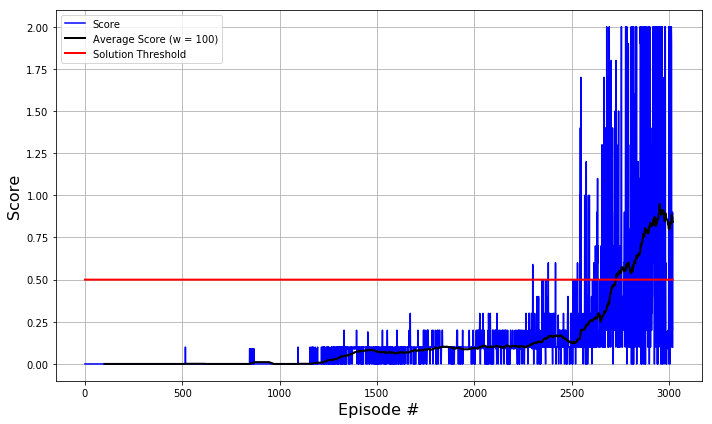

In [19]:
average_scores = np.array([np.mean(scores[i:(i+params['eval_window_length'])])
                           for i in range(len(scores)-params['eval_window_length'])])
steps = len(scores)

fig, ax  = plt.subplots(1,1,figsize=(10, 6))
ax.plot(np.arange(steps), scores, 'b-', linewidth=1.5)
ax.plot(np.arange(params['eval_window_length'], steps), average_scores, 'k-', lw=2)
ax.plot(np.arange(steps), [params['solution_threshold']]*steps, 'r-', lw=2)
ax.set_ylabel('Score', fontsize=16)
ax.set_xlabel('Episode #', fontsize=16)
ax.legend(['Score', 'Average Score (w = 100)', 'Solution Threshold'])
ax.grid(True)
fig.tight_layout()
plt.show()
fig.savefig('rewards.png', dpi=200)

When finished, you can close the environment.

In [20]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 